In [1]:
import pandas as pd
df=pd.read_csv(r"/home/poojan/file2.csv")
df=df[df.columns[1:6]]
df.head()


,BreathingDepth,BreathingRate,Cadence,HeartRate,Intensity
0,6.0,18.750000,0.0,61.000000,0.066881
1,3.0,22.058823,0.0,60.110094,0.058578
2,4.0,18.750000,0.0,58.153725,0.066881
3,4.0,22.058823,0.0,58.761372,0.087361
4,2.0,22.058823,0.0,59.609966,0.087361


In [2]:
df.shape

(36488384, 5)

In [3]:

df1=pd.read_csv(r"/home/poojan/testing/omsignal131.csv")
df=df[['BreathingDepth']]
df1=df1[['BreathingDepth']]
df1.head()

,BreathingDepth
0,5.0
1,6.0
2,5.0
3,5.0
4,4.0


In [4]:
from time import time
import matplotlib.ticker as tkr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

dataset = df1.BreathingDepth.values 
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]



dataset1 = np.reshape(df1, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset1 = scaler.fit_transform(dataset1)
train_size = int(len(dataset1) * 0.75)
test_size = len(dataset1) - train_size
train1, test1 = dataset1[0:train_size,:], dataset1[train_size:len(dataset),:]


Using TensorFlow backend.


In [5]:
# Insert missing rate
df1=df1.to_numpy()
import torch
def produce_NA(X, p_miss, mecha="MCAR", opt=None, p_obs=None, q=None):
   
    to_torch = torch.is_tensor(X) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        X = X.astype(np.float32)
        X = torch.from_numpy(X)
    
    if mecha == "MAR":
        mask = MAR_mask(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(X, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(X, p_miss).double()
    else:
        mask = (torch.rand(X.shape) < p_miss).double()
    
    X_nas = X.clone()
    X_nas[mask.bool()] = np.nan
    
    return {'X_init': X.double(), 'X_incomp': X_nas.double(), 'mask': mask}

import numpy as np
X_miss_mcar = produce_NA(test1, p_miss=0.1, mecha="MCAR")

X_mcar = X_miss_mcar['X_incomp']
R_mcar = X_miss_mcar['mask']

print("Percentage of newly generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

Percentage of newly generated missing values:  10.22521782015453  %


In [6]:
new_test=X_mcar.numpy()
new_test=pd.DataFrame(new_test)
new_test.columns=['BreathingDepth']
new_test=test

In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [8]:
# reshape into X=t and Y=t+1
look_back =64
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
X_impute,Y_impute=create_dataset(test1, look_back)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_impute=np.reshape(X_impute, (X_impute.shape[0], 1, X_impute.shape[1]))

In [9]:
import time
start = time.time()
import os
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
def make_residual_lstm_layers(input, rnn_width, rnn_depth, rnn_dropout):
    x = input
    for i in range(rnn_depth):
        
        return_sequences = i < rnn_depth - 1
        x_rnn = Bidirectional(LSTM(rnn_width, recurrent_dropout=rnn_dropout, dropout=rnn_dropout, 
                     return_sequences=return_sequences))(x)
        
        if return_sequences:
            
            if i > 0 or input.shape[-1] == rnn_width:
                x = add([x, x_rnn])
            else:
                x = x_rnn
        else:
            
            x =LSTM(1, activation='sigmoid', 
                     recurrent_dropout=rnn_dropout, dropout=rnn_dropout, 
                     return_sequences=return_sequences)(x)            
    return x
from keras.layers import Input
from keras.models import Model
input = Input(shape=((1, 64)))
output = make_residual_lstm_layers(input, rnn_width=2, rnn_depth=4, rnn_dropout=0.1)

model = Model(inputs=input, outputs=output)

model.load_weights("training_bd_res_10")
model.compile(loss='mean_squared_error', optimizer='adam')
print("Created model and loaded weights from file")

end = time.time()
print(end - start)

Created model and loaded weights from file
1.299532175064087


In [10]:
import time
start = time.time()

test_predict = model.predict(X_impute)
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_impute])
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
end = time.time()
print(end - start)

Test Mean Absolute Error: 3.3797216185430465
1.5085384845733643


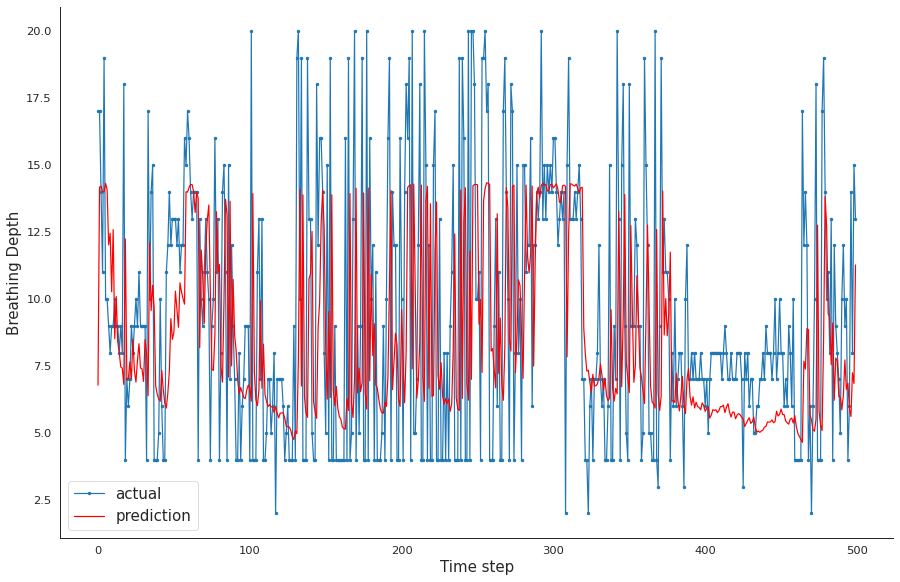

In [11]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
aa=[x for x in range(500)]
plt.figure(figsize=(12,8))
plt.plot(aa, Y_test[0][:500], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:500], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.02)
plt.ylabel('Breathing Depth', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig('Breathing-Depth residual-lstm 10% missing t2')
plt.show();

In [12]:
test_predict=pd.DataFrame(test_predict, columns=['Breathing Depth']).to_csv('BD-10predict2.csv')
